### Instalacja potrzebnych bibliotek

In [1]:
pip install ipywidgets #interaktywne widżety HTML dla notebooków Jupyter i jądra IPython

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#interaktywne'


In [2]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Importowanie wymaganych bibliotek

In [4]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

##### Import bibliotek do stworzenia sieci LSTM

In [5]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)

### Wczytanie bazy

In [6]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
data = pd.read_csv('./zmienne/pzu_d.csv')

### Podzial na zbiór treningowy i testowy

In [7]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(2982, 6)


In [8]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(1789, 6)


In [9]:
# zbiór testowy
ratio = 0.4
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(1192, 6)


In [10]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
count,1789.000000,1789.00000,1789.000000,1789.000000,1.789000e+03
mean,23.489153,23.72325,23.247225,23.488975,3.744297e+06
std,5.451665,5.49418,5.409725,5.446106,4.739787e+06
min,15.367000,15.48600,14.752000,15.220000,3.965050e+05
25%,18.082000,18.25100,17.894000,18.073000,1.990448e+06
50%,23.213000,23.53000,22.906000,23.200000,2.889356e+06
75%,27.821000,28.00900,27.499000,27.797000,4.387589e+06
max,36.471000,36.63400,36.075000,36.340000,1.543167e+08


In [11]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [12]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

In [13]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [47]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

In [15]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 20 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Uczenie modelu

In [48]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2)) 
  model.add(Dense(8))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  history = model.fit(X_train, Y_train, epochs=10, batch_size=10, validation_data=(X_test, Y_test), 
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



## Ewaluacja modelu

In [49]:
#ewaluacja modelu
def evaluation_model(model,X_train, X_test, Y_train, testing=False):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamian typu na float
  dataset = np.reshape(dataset, (-1, 1))  # zmienia shape na odwrotny (odwrócenie macierzy) nie w sposób ciągły (1 pod 2)
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(dataset)
  
#wykonaj prognozy
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_train[0], train_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_train, train_predict, _mean_absolute_error, _mean_squared_error
  return Y_train, train_predict



In [50]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [51]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/10
141/141 [==============================] - 3s 7ms/step - loss: 0.0154 - val_loss: 0.0158
Epoch 2/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0222
Epoch 3/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0294
Epoch 4/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0345
Epoch 5/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0357
Epoch 6/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0118 - val_loss: 0.0368
Epoch 7/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0122 - val_loss: 0.0370
Epoch 8/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0124 - val_loss: 0.0359
Epoch 9/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0128 - val_loss: 0.0338
Epoch 10/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0308

In [52]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


In [53]:

evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 2.3155631967240997
Train Root Mean Squared Error: 2.7125771734785453


(array([[16.62200031, 16.62599967, 16.48100029, ..., 23.01299928,
         23.14300072, 23.13499947]]),
 array([[18.270817, 18.259426, 18.162844, ..., 18.226519, 18.282005,
         18.359797],
        [18.25647 , 18.26043 , 18.208424, ..., 18.284225, 18.2946  ,
         18.340765],
        [18.334127, 18.202492, 18.236448, ..., 18.297255, 18.2047  ,
         18.35308 ],
        ...,
        [25.788725, 25.572763, 25.767809, ..., 25.716528, 25.582214,
         25.877949],
        [25.784483, 25.583614, 25.781918, ..., 25.730885, 25.567787,
         25.78916 ],
        [25.808252, 25.620277, 25.83064 , ..., 25.834227, 25.634602,
         25.811949]], dtype=float32))

In [54]:
Y_train, train_predict = evaluation_model(history,X_train, X_test, Y_train)

Train Mean Absolute Error: 2.3155631967240997
Train Root Mean Squared Error: 2.7125771734785453


In [55]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show();  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



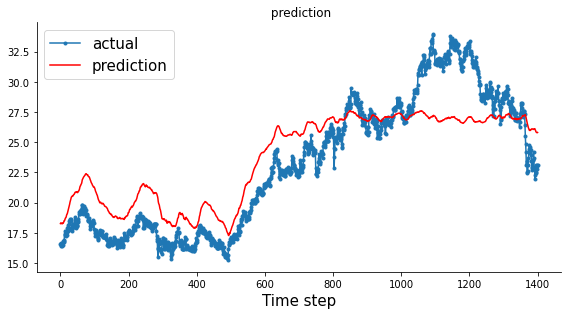

In [56]:
# Na wykresie dane nie są znormalizowane
visualization(Y_train, train_predict) # niebieska- z csv wiersze i do nich wartości z pliku excel (na podstawie ratio nie cale 2849 tylko 0.6 z tego); czerwone- dla poszczegolnych wierszy błędy; model dobrze się uczy

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [57]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 3 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.33986747 0.3432765  0.3751421 ]
 [0.3432765  0.3751421  0.37410045]
 [0.3751421  0.37410045 0.36259472]
 ...
 [0.95653415 0.95620275 0.919413  ]
 [0.95620275 0.919413   0.9337121 ]
 [0.919413   0.9337121  0.9032198 ]]


In [59]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_train, tmp_train_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train, testing=True)
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_train)
    train_predicts.append(tmp_train_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/10
143/143 [==============================] - 3s 7ms/step - loss: 0.0352 - val_loss: 0.0140
Epoch 2/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0194 - val_loss: 0.0058
Epoch 3/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0116 - val_loss: 0.0028
Epoch 4/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 5/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 8.5415e-04
Epoch 6/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 7.7736e-04
Epoch 7/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 7.6608e-04
Epoch 8/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 7.8985e-04
Epoch 9/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 8.7293e-04
Epoch 10/10
143/143 

Epoch 1/10
143/143 [==============================] - 4s 8ms/step - loss: 0.0203 - val_loss: 0.0105
Epoch 2/10
143/143 [==============================] - 1s 4ms/step - loss: 0.0145 - val_loss: 0.0056
Epoch 3/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0033
Epoch 4/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0022
Epoch 5/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 6/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 7/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 8/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 9.7034e-04
Epoch 9/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 9.9863e-04
Epoch 10/10
143/143 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss

141/141 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0228
Epoch 3/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0276
Epoch 4/10
141/141 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0324
Epoch 5/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0099 - val_loss: 0.0379
Epoch 6/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0367
Epoch 7/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0366
Epoch 8/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0113 - val_loss: 0.0331
Epoch 9/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0316
Epoch 10/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0300
Train Mean Absolute Error: 2.164141519571604
Train Root Mean Squared Error: 2.5771396758916487
---------------

141/141 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0319
Epoch 4/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0377
Epoch 5/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0420
Epoch 6/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0437
Epoch 7/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0418
Epoch 8/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0401
Epoch 9/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0394
Epoch 10/10
141/141 [==============================] - 0s 3ms/step - loss: 0.0131 - val_loss: 0.0366
Train Mean Absolute Error: 2.345545913390283
Train Root Mean Squared Error: 2.7883635103375064
-------------------------------39--------------------------
Epoch 1/10
141/141 [==============================] - 3

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [60]:
# wyświetlenie liczby kolumn i wierszy; 2849:1346= 2,1 , a więc 20% (a wcześniej ratio 0.8), więc tak przyjął; model treningowy z predykcją (czerwona linia na wykresie)
train_predict.shape

(1401, 8)

In [61]:
error_look_back[3]["MSE"]

[0.5508739863750565,
 0.5789791591576672,
 0.6556969984784794,
 0.6697693741329788,
 0.6086126938696281,
 0.5905208019817765,
 0.5918309533354236,
 0.6217790053721448,
 0.5726201689250107,
 0.5931443784532742]

In [62]:
error_look_back[3]["MAE"]

[0.44908764334554174,
 0.47127798271670496,
 0.5485151319185436,
 0.563784366051788,
 0.5035234221146697,
 0.4806274441915317,
 0.4883858114367483,
 0.5165052167001798,
 0.4638507536747513,
 0.4810210074528901]

In [63]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[2.5771396758916487, 2.6450224750279325, 2.7518470558194674, 2.7879828818106267, 2.7883635103375064, 2.789874931661909, 2.880907047907143, 2.9355039926977198, 3.157268167557547, 3.1670671614297308]


<AxesSubplot:>

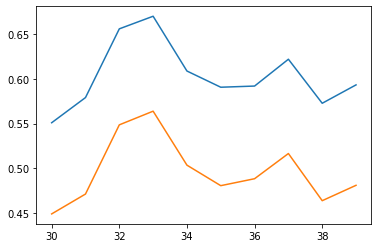

In [64]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3 
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


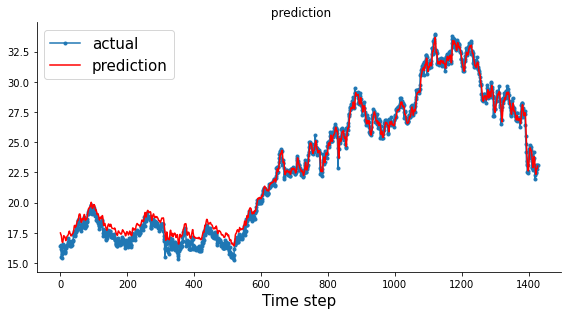

In [65]:
batch_index = 9 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3 #jak to wyrzucimy, to tez bedzie dzialac
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [66]:
error_look_back[3]["Y_trains"][0]

array([[16.4349994 , 16.52699993, 16.19499964, ..., 23.01299928,
        23.14300072, 23.13499947]])